# Sales order data exploration

Use the code in this notebook to explore sales order data.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import *
from pyspark.sql.types import *
from delta.tables import *
from pyspark.sql.functions import col, dayofmonth, month, year, date_format
import findspark
import zipfile 
import os
from pyspark.sql.functions import when, lit, col, current_timestamp, input_file_name
import pandas as pd
import requests

/tmp/ipykernel_3014/2081569771.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
findspark.init()
spark = SparkSession.builder.appName("sparksql").getOrCreate()
%load_ext sparksql_magic
%config SparkSql.max_num_rows=20

/home/radek/git_projekty/sparkTraining/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3493: UserWarning: Config option `max_num_rows` not recognized by `SparkSql`.
  if await self.run_code(code, result, async_=asy):


In [36]:
datafabric_baseurl = "/home/radek/git_projekty/sparkTraining/datafabrictraining"

In [9]:
df = spark.read.format("csv").option("header","true").load("/home/radek/git_projekty/sparkTraining/orders/2019.csv")
# df = spark.read.format("csv").option("header","true").load("abfss://420c196f-1dff-4a10-960e-cb2b82bac5fb@onelake.dfs.fabric.microsoft.com/041002d6-72a1-41a6-8711-db0afa5e63b6/Files/orders/2019.csv")
# df now is a Spark DataFrame containing CSV data from "abfss://420c196f-1dff-4a10-960e-cb2b82bac5fb@onelake.dfs.fabric.microsoft.com/041002d6-72a1-41a6-8711-db0afa5e63b6/Files/orders/2019.csv".
display(df)
print(df.head())

DataFrame[SO43701: string, 11: string, 2019-07-01: string, Christy Zhu: string, christy12@adventure-works.com: string, Mountain-100 Silver, 44: string, 16: string, 3399.99: string, 271.9992: string]

Row(SO43701='SO43704', 11='1', 2019-07-01='2019-07-01', Christy Zhu='Julio Ruiz', christy12@adventure-works.com='julio1@adventure-works.com', Mountain-100 Silver, 44='Mountain-100 Black, 48', 16='1', 3399.99='3374.99', 271.9992='269.9992')


24/03/06 08:17:56 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: SO43701, 1, 2019-07-01, Christy Zhu, christy12@adventure-works.com, Mountain-100 Silver, 44, 1, 3399.99, 271.9992
 Schema: SO43701, 11, 2019-07-01, Christy Zhu, christy12@adventure-works.com, Mountain-100 Silver, 44, 16, 3399.99, 271.9992
Expected: 11 but found: 1
CSV file: file:///home/radek/git_projekty/sparkTraining/orders/2019.csv


In [14]:
df = spark.read.format("csv").option("header","false").load("/home/radek/git_projekty/sparkTraining/orders/2019.csv")
# df = spark.read.format("csv").option("header","false").load("abfss://420c196f-1dff-4a10-960e-cb2b82bac5fb@onelake.dfs.fabric.microsoft.com/041002d6-72a1-41a6-8711-db0afa5e63b6/Files/orders/2019.csv")
# df now is a Spark DataFrame containing CSV data from "abfss://420c196f-1dff-4a10-960e-cb2b82bac5fb@onelake.dfs.fabric.microsoft.com/041002d6-72a1-41a6-8711-db0afa5e63b6/Files/orders/2019.csv".
display(df)
df.show(3)

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string]

+-------+---+----------+-----------+--------------------+--------------------+---+-------+--------+
|    _c0|_c1|       _c2|        _c3|                 _c4|                 _c5|_c6|    _c7|     _c8|
+-------+---+----------+-----------+--------------------+--------------------+---+-------+--------+
|SO43701|  1|2019-07-01|Christy Zhu|christy12@adventu...|Mountain-100 Silv...|  1|3399.99|271.9992|
|SO43704|  1|2019-07-01| Julio Ruiz|julio1@adventure-...|Mountain-100 Blac...|  1|3374.99|269.9992|
|SO43705|  1|2019-07-01|  Curtis Lu|curtis9@adventure...|Mountain-100 Silv...|  1|3399.99|271.9992|
+-------+---+----------+-----------+--------------------+--------------------+---+-------+--------+
only showing top 3 rows



In [13]:
from pyspark.sql.types import *

orderSchema = StructType([
    StructField("SalesOrderNumber", StringType()),
    StructField("SalesOrderLineNumber", IntegerType()),
    StructField("OrderDate", DateType()),
    StructField("CustomerName", StringType()),
    StructField("Email", StringType()),
    StructField("Item", StringType()),
    StructField("Quantity", IntegerType()),
    StructField("UnitPrice", FloatType()),
    StructField("Tax", FloatType())
    ])

df = spark.read.format("csv").schema(orderSchema).load("/home/radek/git_projekty/sparkTraining/orders/2019.csv")
display(df)
df.show(3)

DataFrame[SalesOrderNumber: string, SalesOrderLineNumber: int, OrderDate: date, CustomerName: string, Email: string, Item: string, Quantity: int, UnitPrice: float, Tax: float]

+----------------+--------------------+----------+------------+--------------------+--------------------+--------+---------+--------+
|SalesOrderNumber|SalesOrderLineNumber| OrderDate|CustomerName|               Email|                Item|Quantity|UnitPrice|     Tax|
+----------------+--------------------+----------+------------+--------------------+--------------------+--------+---------+--------+
|         SO43701|                   1|2019-07-01| Christy Zhu|christy12@adventu...|Mountain-100 Silv...|       1|  3399.99|271.9992|
|         SO43704|                   1|2019-07-01|  Julio Ruiz|julio1@adventure-...|Mountain-100 Blac...|       1|  3374.99|269.9992|
|         SO43705|                   1|2019-07-01|   Curtis Lu|curtis9@adventure...|Mountain-100 Silv...|       1|  3399.99|271.9992|
+----------------+--------------------+----------+------------+--------------------+--------------------+--------+---------+--------+
only showing top 3 rows



In [15]:
display(df)
df.show(5)

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string]

+-------+---+----------+--------------+--------------------+--------------------+---+--------+--------+
|    _c0|_c1|       _c2|           _c3|                 _c4|                 _c5|_c6|     _c7|     _c8|
+-------+---+----------+--------------+--------------------+--------------------+---+--------+--------+
|SO43701|  1|2019-07-01|   Christy Zhu|christy12@adventu...|Mountain-100 Silv...|  1| 3399.99|271.9992|
|SO43704|  1|2019-07-01|    Julio Ruiz|julio1@adventure-...|Mountain-100 Blac...|  1| 3374.99|269.9992|
|SO43705|  1|2019-07-01|     Curtis Lu|curtis9@adventure...|Mountain-100 Silv...|  1| 3399.99|271.9992|
|SO43700|  1|2019-07-01|  Ruben Prasad|ruben10@adventure...|  Road-650 Black, 62|  1|699.0982| 55.9279|
|SO43703|  1|2019-07-01|Albert Alvarez|albert7@adventure...|    Road-150 Red, 62|  1| 3578.27|286.2616|
+-------+---+----------+--------------+--------------------+--------------------+---+--------+--------+
only showing top 5 rows



In [17]:
from pyspark.sql.types import *

orderSchema = StructType([
    StructField("SalesOrderNumber", StringType()),
    StructField("SalesOrderLineNumber", IntegerType()),
    StructField("OrderDate", DateType()),
    StructField("CustomerName", StringType()),
    StructField("Email", StringType()),
    StructField("Item", StringType()),
    StructField("Quantity", IntegerType()),
    StructField("UnitPrice", FloatType()),
    StructField("Tax", FloatType())
    ])

df = spark.read.format("csv").schema(orderSchema).load("/home/radek/git_projekty/sparkTraining/orders/*.csv")
display(df)
df.show(5)

DataFrame[SalesOrderNumber: string, SalesOrderLineNumber: int, OrderDate: date, CustomerName: string, Email: string, Item: string, Quantity: int, UnitPrice: float, Tax: float]

+----------------+--------------------+----------+--------------+--------------------+--------------------+--------+---------+--------+
|SalesOrderNumber|SalesOrderLineNumber| OrderDate|  CustomerName|               Email|                Item|Quantity|UnitPrice|     Tax|
+----------------+--------------------+----------+--------------+--------------------+--------------------+--------+---------+--------+
|         SO49171|                   1|2021-01-01| Mariah Foster|mariah21@adventur...|  Road-250 Black, 48|       1|2181.5625| 174.525|
|         SO49172|                   1|2021-01-01|  Brian Howard|brian23@adventure...|    Road-250 Red, 44|       1|  2443.35| 195.468|
|         SO49173|                   1|2021-01-01| Linda Alvarez|linda19@adventure...|Mountain-200 Silv...|       1|2071.4197|165.7136|
|         SO49174|                   1|2021-01-01|Gina Hernandez|gina4@adventure-w...|Mountain-200 Silv...|       1|2071.4197|165.7136|
|         SO49178|                   1|2021-01-0

In [21]:
customers = df['CustomerName', 'Email']
print(customers.count())
print(customers.distinct().count())
display(customers.distinct())
customers.distinct().show(5)

32718
12427


DataFrame[CustomerName: string, Email: string]

+----------------+--------------------+
|    CustomerName|               Email|
+----------------+--------------------+
|Bridget Andersen|bridget15@adventu...|
|      Mya Butler|mya14@adventure-w...|
|Deanna Hernandez|deanna29@adventur...|
|   Ricky Navarro|ricky10@adventure...|
|         Omar Ye|omar9@adventure-w...|
+----------------+--------------------+
only showing top 5 rows



In [20]:
customers = df['CustomerName', 'Email']
print(customers.count())
print(customers.distinct().count())
display(customers.distinct())
customers.distinct().show()

32718
12427


DataFrame[CustomerName: string, Email: string]

+----------------+--------------------+
|    CustomerName|               Email|
+----------------+--------------------+
|Bridget Andersen|bridget15@adventu...|
|      Mya Butler|mya14@adventure-w...|
|Deanna Hernandez|deanna29@adventur...|
|   Ricky Navarro|ricky10@adventure...|
|         Omar Ye|omar9@adventure-w...|
|Kellie Gutierrez|kellie9@adventure...|
|    Raymond Rana|raymond13@adventu...|
|  Derrick Moreno|derrick6@adventur...|
|    Megan Walker|megan25@adventure...|
|  Edward Jackson|edward34@adventur...|
|       Wayne She|wayne1@adventure-...|
|     Willie Shan|willie29@adventur...|
|        Jake Guo|jake15@adventure-...|
|       Sandra Lu|sandra18@adventur...|
|      Adam Kumar|adam24@adventure-...|
|  Lawrence Ramos|lawrence16@advent...|
|  Abigail Garcia|abigail57@adventu...|
|        Jan Hall|jan18@adventure-w...|
| Logan Patterson|logan13@adventure...|
|     Connor Ross|connor0@adventure...|
+----------------+--------------------+
only showing top 20 rows



In [23]:
# productSales = df.select("Item", "Quantity").groupBy("Item").sum()
productSales = df.select("Item", "Quantity").groupBy("Item").sum().orderBy("Item")
display(productSales)
productSales.show(5)

DataFrame[Item: string, sum(Quantity): bigint]

+--------------------+-------------+
|                Item|sum(Quantity)|
+--------------------+-------------+
|        AWC Logo Cap|         1063|
|All-Purpose Bike ...|          135|
|Bike Wash - Disso...|          473|
|     Classic Vest, L|           84|
|     Classic Vest, M|           92|
+--------------------+-------------+
only showing top 5 rows



In [27]:
from pyspark.sql.functions import *

yearlySales = df.select(year("OrderDate").alias("Year")).groupBy("Year").count().orderBy("Year")
display(yearlySales)
yearlySales.show(5)

DataFrame[Year: int, count: bigint]

+----+-----+
|Year|count|
+----+-----+
|2019| 1201|
|2020| 2733|
|2021|28784|
+----+-----+



In [30]:
from pyspark.sql.functions import *

## Create Year and Month columns
transformed_df = df.withColumn("Year", year(col("OrderDate"))).withColumn("Month", month(col("OrderDate")))

# Create the new FirstName and LastName fields
transformed_df = transformed_df.withColumn("FirstName", split(col("CustomerName"), " ").getItem(0)).withColumn("LastName", split(col("CustomerName"), " ").getItem(1))

# Filter and reorder columns
transformed_df = transformed_df["SalesOrderNumber", "SalesOrderLineNumber", "OrderDate", "Year", "Month", "FirstName", "LastName", "Email", "Item", "Quantity", "UnitPrice", "Tax"]

# Display the first five orders
display(transformed_df.limit(5))
transformed_df.limit(5).orderBy("Tax").show()

DataFrame[SalesOrderNumber: string, SalesOrderLineNumber: int, OrderDate: date, Year: int, Month: int, FirstName: string, LastName: string, Email: string, Item: string, Quantity: int, UnitPrice: float, Tax: float]

+----------------+--------------------+----------+----+-----+---------+---------+--------------------+--------------------+--------+---------+--------+
|SalesOrderNumber|SalesOrderLineNumber| OrderDate|Year|Month|FirstName| LastName|               Email|                Item|Quantity|UnitPrice|     Tax|
+----------------+--------------------+----------+----+-----+---------+---------+--------------------+--------------------+--------+---------+--------+
|         SO49178|                   1|2021-01-01|2021|    1|     Beth|     Ruiz|beth4@adventure-w...|Road-550-W Yellow...|       1|1000.4375|  80.035|
|         SO49173|                   1|2021-01-01|2021|    1|    Linda|  Alvarez|linda19@adventure...|Mountain-200 Silv...|       1|2071.4197|165.7136|
|         SO49174|                   1|2021-01-01|2021|    1|     Gina|Hernandez|gina4@adventure-w...|Mountain-200 Silv...|       1|2071.4197|165.7136|
|         SO49171|                   1|2021-01-01|2021|    1|   Mariah|   Foster|mariah2

In [34]:
transformed_df.limit(5).orderBy("Tax",ascending=False).show()

+----------------+--------------------+----------+----+-----+---------+---------+--------------------+--------------------+--------+---------+--------+
|SalesOrderNumber|SalesOrderLineNumber| OrderDate|Year|Month|FirstName| LastName|               Email|                Item|Quantity|UnitPrice|     Tax|
+----------------+--------------------+----------+----+-----+---------+---------+--------------------+--------------------+--------+---------+--------+
|         SO49172|                   1|2021-01-01|2021|    1|    Brian|   Howard|brian23@adventure...|    Road-250 Red, 44|       1|  2443.35| 195.468|
|         SO49171|                   1|2021-01-01|2021|    1|   Mariah|   Foster|mariah21@adventur...|  Road-250 Black, 48|       1|2181.5625| 174.525|
|         SO49173|                   1|2021-01-01|2021|    1|    Linda|  Alvarez|linda19@adventure...|Mountain-200 Silv...|       1|2071.4197|165.7136|
|         SO49174|                   1|2021-01-01|2021|    1|     Gina|Hernandez|gina4@a

In [35]:
transformed_df.write.mode("overwrite").parquet('/home/radek/git_projekty/sparkTraining/datafabrictraining/Files/transformed_data/orders')
# transformed_df.write.mode("overwrite").parquet('Files/transformed_data/orders')
print ("Transformed data saved!")

Transformed data saved!


In [37]:
orders_df = spark.read.format("parquet").load( os.path.join(datafabric_baseurl, "Files/transformed_data/orders"))
display(orders_df)
orders_df.show(5)

DataFrame[SalesOrderNumber: string, SalesOrderLineNumber: int, OrderDate: date, Year: int, Month: int, FirstName: string, LastName: string, Email: string, Item: string, Quantity: int, UnitPrice: float, Tax: float]

+----------------+--------------------+----------+----+-----+---------+---------+--------------------+--------------------+--------+---------+--------+
|SalesOrderNumber|SalesOrderLineNumber| OrderDate|Year|Month|FirstName| LastName|               Email|                Item|Quantity|UnitPrice|     Tax|
+----------------+--------------------+----------+----+-----+---------+---------+--------------------+--------------------+--------+---------+--------+
|         SO49171|                   1|2021-01-01|2021|    1|   Mariah|   Foster|mariah21@adventur...|  Road-250 Black, 48|       1|2181.5625| 174.525|
|         SO49172|                   1|2021-01-01|2021|    1|    Brian|   Howard|brian23@adventure...|    Road-250 Red, 44|       1|  2443.35| 195.468|
|         SO49173|                   1|2021-01-01|2021|    1|    Linda|  Alvarez|linda19@adventure...|Mountain-200 Silv...|       1|2071.4197|165.7136|
|         SO49174|                   1|2021-01-01|2021|    1|     Gina|Hernandez|gina4@a

In [39]:
orders_df.write.partitionBy("Year","Month").mode("overwrite").parquet( os.path.join( datafabric_baseurl, "Files/partitioned_data"))
print ("Transformed data saved!")
print( os.listdir( os.path.join(datafabric_baseurl, "Files/partitioned_data")))

Transformed data saved!
['Year=2021', '_SUCCESS', '._SUCCESS.crc', 'Year=2019', 'Year=2020']


In [40]:
orders_2021_df = spark.read.format("parquet").load( os.path.join( datafabric_baseurl, "Files/partitioned_data/Year=2021/Month=*"))
display(orders_2021_df)
orders_2021_df.show(5)

DataFrame[SalesOrderNumber: string, SalesOrderLineNumber: int, OrderDate: date, FirstName: string, LastName: string, Email: string, Item: string, Quantity: int, UnitPrice: float, Tax: float]

+----------------+--------------------+----------+---------+--------+--------------------+--------------------+--------+---------+-------+
|SalesOrderNumber|SalesOrderLineNumber| OrderDate|FirstName|LastName|               Email|                Item|Quantity|UnitPrice|    Tax|
+----------------+--------------------+----------+---------+--------+--------------------+--------------------+--------+---------+-------+
|         SO59195|                   1|2021-11-01|   Alexia|   Hayes|alexia19@adventur...|Touring-2000 Blue...|       1|  1214.85| 97.188|
|         SO59195|                   2|2021-11-01|   Alexia|   Hayes|alexia19@adventur...|     Racing Socks, M|       1|     8.99| 0.7192|
|         SO59196|                   1|2021-11-01|  Anthony|  Garcia|anthony2@adventur...|Touring-2000 Blue...|       1|  1214.85| 97.188|
|         SO59196|                   2|2021-11-01|  Anthony|  Garcia|anthony2@adventur...|Sport-100 Helmet,...|       1|    34.99| 2.7992|
|         SO59191|         

In [47]:
# Create a new table
# df.write.format("delta").saveAsTable( "salesorders") # required some package
''' 
It seems like you’re trying to use the Delta Lake format, but Spark can’t find it. This error is often caused by one of the following reasons:

The Delta Lake package is not installed in your environment.
The Delta Lake package is not correctly linked with Spark.
You can solve this issue by ensuring that the Delta Lake package is properly installed and linked. Here’s how you can do it:

Install the Delta Lake package: You can add the Delta Lake package to your Spark project by including it in your build.sbt, pom.xml (for Maven), or build.gradle file. You can find the package at https://spark.apache.org/third-party-projects.html.
Link the Delta Lake package with Spark: If you’re using PySpark, you can link the Delta Lake package with Spark by setting the PYSPARK_SUBMIT_ARGS environment variable before launching PySpark. Here’s an example:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages io.delta:delta-core_2.12:1.0.0 pyspark-shell'
'''
# instead of this use just view 
# df.createOrReplaceTempView("salesorders_view")
df.createOrReplaceTempView("salesorders")
#Get the table description
spark.sql("DESCRIBE EXTENDED salesorders").show(truncate=False)
view = spark.sql("SELECT * FROM salesorders_view limit 5")
view.show()

+--------------------+---------+-------+
|col_name            |data_type|comment|
+--------------------+---------+-------+
|SalesOrderNumber    |string   |NULL   |
|SalesOrderLineNumber|int      |NULL   |
|OrderDate           |date     |NULL   |
|CustomerName        |string   |NULL   |
|Email               |string   |NULL   |
|Item                |string   |NULL   |
|Quantity            |int      |NULL   |
|UnitPrice           |float    |NULL   |
|Tax                 |float    |NULL   |
+--------------------+---------+-------+

+----------------+--------------------+----------+--------------+--------------------+--------------------+--------+---------+--------+
|SalesOrderNumber|SalesOrderLineNumber| OrderDate|  CustomerName|               Email|                Item|Quantity|UnitPrice|     Tax|
+----------------+--------------------+----------+--------------+--------------------+--------------------+--------+---------+--------+
|         SO49171|                   1|2021-01-01| Mariah 

In [21]:
df = spark.sql("SELECT * FROM wwilakehouse.salesorders LIMIT 1000")
display(df)

StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 23, Finished, Available)

SynapseWidget(Synapse.DataFrame, 6cb1b9f7-0796-4605-9dc5-17a98a4752d1)

In [28]:
# error path should be to files/external_salesorder
#df.write.format("delta").saveAsTable("external_salesorder", path="abfss://dp_Fabric29@onelake.dfs.fabric.microsoft.com/Fabric_lakehouse.Lakehouse/Files/external_salesorder")

StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 30, Finished, Available)

In [27]:
df.write.format("delta").saveAsTable("external_salesorder", path="abfss://420c196f-1dff-4a10-960e-cb2b82bac5fb@onelake.dfs.fabric.microsoft.com/041002d6-72a1-41a6-8711-db0afa5e63b6/Files/external_salesorder")

StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 29, Finished, Available)

In [29]:
%%sql
DESCRIBE FORMATTED salesorders;

StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 31, Finished, Available)

<Spark SQL result set with 17 rows and 3 fields>

In [31]:
%%sql

DESCRIBE FORMATTED external_salesorder;


StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 33, Finished, Available)

<Spark SQL result set with 17 rows and 3 fields>

In [32]:
%%sql
SELECT YEAR(OrderDate) AS OrderYear,
    SUM((UnitPrice * Quantity) + Tax) AS GrossRevenue
FROM salesorders
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear;

StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 34, Finished, Available)

<Spark SQL result set with 3 rows and 2 fields>

In [33]:
%%sql
SELECT * FROM salesorders

StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 35, Finished, Available)

<Spark SQL result set with 1000 rows and 9 fields>

In [34]:
sqlQuery = "SELECT CAST(YEAR(OrderDate) AS CHAR(4)) AS OrderYear, \
            SUM((UnitPrice * Quantity) + Tax) AS GrossRevenue \
        FROM salesorders \
        GROUP BY CAST(YEAR(OrderDate) AS CHAR(4)) \
        ORDER BY OrderYear"
df_spark = spark.sql(sqlQuery)
df_spark.show()

StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 36, Finished, Available)

+---------+--------------------+
|OrderYear|        GrossRevenue|
+---------+--------------------+
|     2019|   4172169.969970703|
|     2020|   6882259.268127441|
|     2021|1.1547835291696548E7|
+---------+--------------------+



StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 37, Finished, Available)

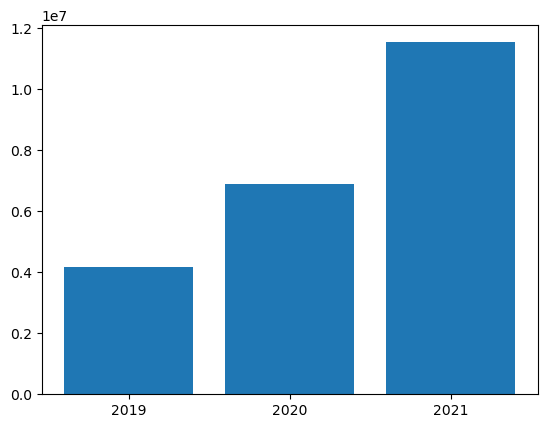

In [35]:
from matplotlib import pyplot as plt

# matplotlib requires a Pandas dataframe, not a Spark one
df_sales = df_spark.toPandas()

# Create a bar plot of revenue by year
plt.bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'])

# Display the plot
plt.show()

StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 38, Finished, Available)

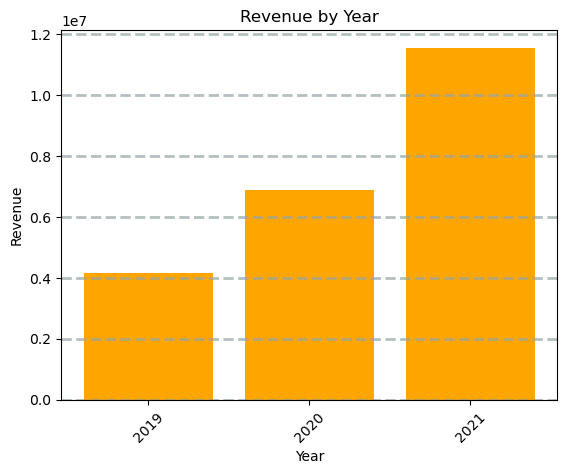

In [36]:
from matplotlib import pyplot as plt

# Clear the plot area
plt.clf()

# Create a bar plot of revenue by year
plt.bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'], color='orange')

# Customize the chart
plt.title('Revenue by Year')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xticks(rotation=45)

# Show the figure
plt.show()

StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 39, Finished, Available)

<Figure size 640x480 with 0 Axes>

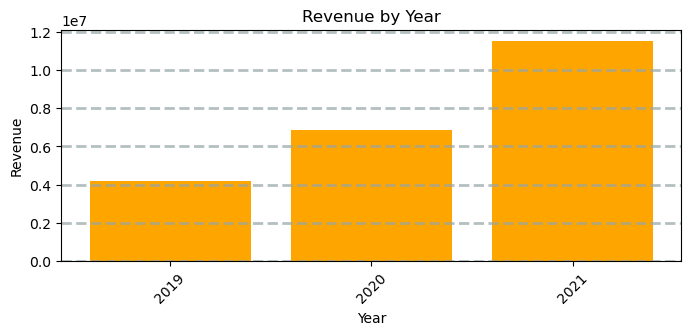

In [37]:
from matplotlib import pyplot as plt

# Clear the plot area
plt.clf()

# Create a Figure
fig = plt.figure(figsize=(8,3))

# Create a bar plot of revenue by year
plt.bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'], color='orange')

# Customize the chart
plt.title('Revenue by Year')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xticks(rotation=45)

# Show the figure
plt.show()

StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 40, Finished, Available)

<Figure size 640x480 with 0 Axes>

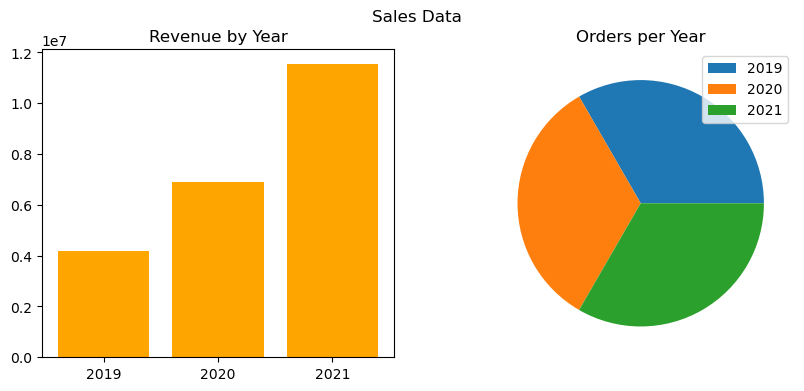

In [38]:
from matplotlib import pyplot as plt

# Clear the plot area
plt.clf()

# Create a figure for 2 subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize = (10,4))

# Create a bar plot of revenue by year on the first axis
ax[0].bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'], color='orange')
ax[0].set_title('Revenue by Year')

# Create a pie chart of yearly order counts on the second axis
yearly_counts = df_sales['OrderYear'].value_counts()
ax[1].pie(yearly_counts)
ax[1].set_title('Orders per Year')
ax[1].legend(yearly_counts.keys().tolist())

# Add a title to the Figure
fig.suptitle('Sales Data')

# Show the figure
plt.show()

StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 41, Finished, Available)

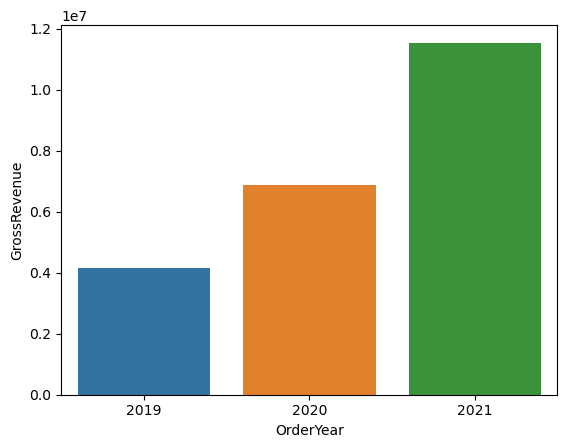

In [39]:
import seaborn as sns

# Clear the plot area
plt.clf()

# Create a bar chart
ax = sns.barplot(x="OrderYear", y="GrossRevenue", data=df_sales)
plt.show()

StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 42, Finished, Available)

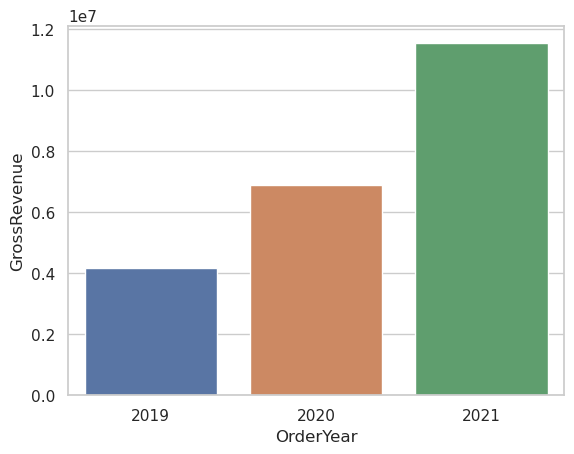

In [40]:
import seaborn as sns

# Clear the plot area
plt.clf()

# Set the visual theme for seaborn
sns.set_theme(style="whitegrid")

# Create a bar chart
ax = sns.barplot(x="OrderYear", y="GrossRevenue", data=df_sales)
plt.show()

StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 43, Finished, Available)

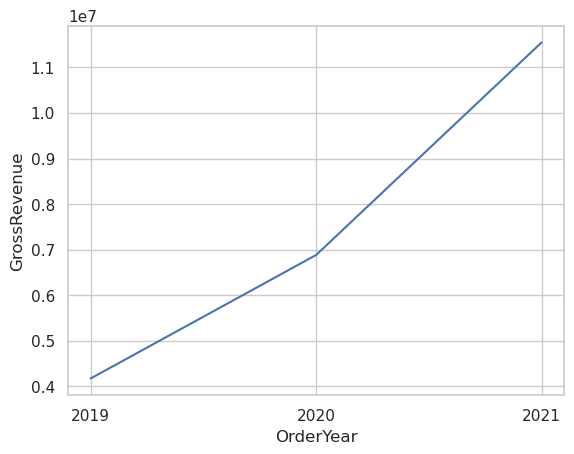

In [41]:
import seaborn as sns

# Clear the plot area
plt.clf()

# Create a bar chart
ax = sns.lineplot(x="OrderYear", y="GrossRevenue", data=df_sales)
plt.show()

In [42]:
from notebookutils import mssparkutils
from pyspark.sql.types import *
from pyspark.sql.functions import *

# Create a folder
inputPath = 'Files/data/'
mssparkutils.fs.mkdirs(inputPath)

# Create a stream that reads data from the folder, using a JSON schema
jsonSchema = StructType([
StructField("device", StringType(), False),
StructField("status", StringType(), False)
])
iotstream = spark.readStream.schema(jsonSchema).option("maxFilesPerTrigger", 1).json(inputPath)

# Write some event data to the folder
device_data = '''{"device":"Dev1","status":"ok"}
{"device":"Dev1","status":"ok"}
{"device":"Dev1","status":"ok"}
{"device":"Dev2","status":"error"}
{"device":"Dev1","status":"ok"}
{"device":"Dev1","status":"error"}
{"device":"Dev2","status":"ok"}
{"device":"Dev2","status":"error"}
{"device":"Dev1","status":"ok"}'''
mssparkutils.fs.put(inputPath + "data.txt", device_data, True)
print("Source stream created...")

StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 44, Finished, Available)

Source stream created...


In [43]:
# Write the stream to a delta table
delta_stream_table_path = 'Tables/iotdevicedata'
checkpointpath = 'Files/delta/checkpoint'
deltastream = iotstream.writeStream.format("delta").option("checkpointLocation", checkpointpath).start(delta_stream_table_path)
print("Streaming to delta sink...")

StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 45, Finished, Available)

Streaming to delta sink...


In [45]:
%%sql

SELECT * FROM IotDeviceData;

StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 47, Finished, Available)

<Spark SQL result set with 9 rows and 2 fields>

In [46]:
# Add more data to the source stream
more_data = '''{"device":"Dev1","status":"ok"}
{"device":"Dev1","status":"ok"}
{"device":"Dev1","status":"ok"}
{"device":"Dev1","status":"ok"}
{"device":"Dev1","status":"error"}
{"device":"Dev2","status":"error"}
{"device":"Dev1","status":"ok"}'''

mssparkutils.fs.put(inputPath + "more-data.txt", more_data, True)

StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 48, Finished, Available)

True

In [47]:
%%sql

SELECT * FROM IotDeviceData;

StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 49, Finished, Available)

<Spark SQL result set with 16 rows and 2 fields>

In [48]:
%%sql

SELECT * FROM IotDeviceData;

StatementMeta(, c053aa84-b7a6-4634-8b5c-8ab66ff5e6af, 50, Finished, Available)

<Spark SQL result set with 16 rows and 2 fields>